In [1]:
# Lets import the required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# We are using sklearn library and stats model library for this model
from sklearn.model_selection import train_test_split # for spliting the data
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler # scaler and encoder: to prepare the data for the model
from sklearn.metrics import r2_score # a way to check the model performance
import statsmodels.api as stat # statsmodel: this is the classifier we will be using OLS model
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif # a way to check the significance of the columns used for model building
from statsmodels.stats.stattools import durbin_watson # a way to check the performance and stability of model

from sklearn.linear_model import LinearRegression as LR # sklearn: classifier OLS model
from sklearn.metrics import mean_squared_error


In [2]:
# We will be using Housing data for this model, remember Liner regression model is a supervised target dependent model
# It is used to predict a change in y when x changes by a unit
data = pd.read_csv('/content/drive/MyDrive/Input/Housing.csv')
data.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


Lets take a look at the categorical columns and decide what should be used to encode it. Remember, we need to encode it, then scale the data.

In [3]:
col = [x for x in data.columns if data[x].dtype == "O"]
for columns in col:
  print(columns, "has", data[columns].nunique() ,"unique values, that are", "(",data[columns].unique(),")")

mainroad has 2 unique values, that are ( ['yes' 'no'] )
guestroom has 2 unique values, that are ( ['no' 'yes'] )
basement has 2 unique values, that are ( ['no' 'yes'] )
hotwaterheating has 2 unique values, that are ( ['no' 'yes'] )
airconditioning has 2 unique values, that are ( ['yes' 'no'] )
prefarea has 2 unique values, that are ( ['yes' 'no'] )
furnishingstatus has 3 unique values, that are ( ['furnished' 'semi-furnished' 'unfurnished'] )


We can use get dummies to encode the data or we can use OneHotEncoder, LabelEncoder to encode the data. Get dummies should be used in EDA, I wouldn't recomend using it in ML models, we have better options available.
LabelEncoder should be used if the variables are ordinal (have an order) and OneHotEncoder should be used for nominal (no order) categorical variable.

We will be using OneHotEncoder and then we will have to scale the numerical data and not the One hot encoded data as it will be already be in between 0 and 1.

In [4]:
# Encoding categorical columns
encoder = OneHotEncoder(sparse_output=False, dtype = "int" , drop = 'first')
encoded_data = encoder.fit_transform(data[col])
encoded_data = pd.DataFrame(encoded_data, columns = encoder.get_feature_names_out())
encoded_data = pd.concat([data.drop(col, axis = 1), encoded_data], axis=1)

In [5]:
encoded_data.head()

,price,area,bedrooms,bathrooms,stories,parking,mainroad_yes,guestroom_yes,basement_yes,hotwaterheating_yes,airconditioning_yes,prefarea_yes,furnishingstatus_semi-furnished,furnishingstatus_unfurnished
0,13300000,7420,4,2,3,2,1,0,0,0,1,1,0,0
1,12250000,8960,4,4,4,3,1,0,0,0,1,0,0,0
2,12250000,9960,3,2,2,2,1,0,1,0,0,1,1,0
3,12215000,7500,4,2,2,3,1,0,1,0,1,1,0,0
4,11410000,7420,4,1,2,2,1,1,1,0,1,0,0,0


Now, we can split the data into 2 parts, one for testing and one for training. After spliting, we can scale training and testing data. After scaling, remember, we still have not seprated dependent and independent columns. So, we will have to seprate them in both sets (training and testing).

In [6]:
#Train test split
train, test = train_test_split(encoded_data, test_size = 0.3, random_state= 50)


# Using StandardScaler

In the below code, I have seprated the categorical columns which was encoded above, then scaled only the numerical columns and merged both of them again at the end to get the final data frame which will be used by the model later.

In [7]:
# Lets deal with training data first.
scaler =  StandardScaler()
num_col = [y for y in data.columns if data[y].dtype != 'O']
# seprating columns that were earlier categorical from numerical columns
train_cat = train.drop(num_col, axis = 1)
train_num = train[num_col]
# Scaling numerical columns
train_num_scaled = scaler.fit_transform(train_num)
train_num_scaled = pd.DataFrame(train_num_scaled, columns = train_num.columns, index =train_num.index)
# Now since, we have scaled the necessary part of the training data, we can merge it with the Train_cat to get a proper DataFrame
training_data = pd.concat([train_num_scaled, train_cat], axis = 1 )
training_data.head()

,price,area,bedrooms,bathrooms,stories,parking,mainroad_yes,guestroom_yes,basement_yes,hotwaterheating_yes,airconditioning_yes,prefarea_yes,furnishingstatus_semi-furnished,furnishingstatus_unfurnished
339,-0.487209,-0.911766,1.486932,1.390600,0.253703,-0.817132,1,0,0,0,0,0,0,0
63,1.208893,0.507408,1.486932,1.390600,1.418291,1.559412,1,0,0,0,1,1,0,0
158,0.379687,1.230383,0.077676,-0.586335,-0.910885,1.559412,1,0,0,0,0,0,1,0
203,0.059312,0.078978,1.486932,-0.586335,0.253703,-0.817132,1,0,0,0,0,0,1,0
482,-0.996040,-0.925155,0.077676,-0.586335,0.253703,-0.817132,0,0,0,0,0,0,0,1


Apart from this, there is an easier way of doing this with only a couple of lines of code, but that requires changing the original data. If we proceed with this, we will not be able to use the original data again.

train[num_col] = scaler.fit_transform(train[num_col])

this line would have produced the same result but would have compromised the original data.

So, since we have to scale the test data as well. I will be using this short method and to save the original data for later use, I will create a deep copy of it.

In [8]:
test_deep_copy = test.copy(deep = True)
test_deep_copy[num_col] = scaler.transform(test_deep_copy[num_col])
test_deep_copy.head()
# this way, we still have the origional train and test data untouched.

,price,area,bedrooms,bathrooms,stories,parking,mainroad_yes,guestroom_yes,basement_yes,hotwaterheating_yes,airconditioning_yes,prefarea_yes,furnishingstatus_semi-furnished,furnishingstatus_unfurnished
333,-0.468364,-0.992097,0.077676,-0.586335,0.253703,-0.817132,1,0,0,0,0,0,1,0
37,1.717723,1.685590,1.486932,1.390600,2.582878,1.559412,1,0,0,0,1,0,0,0
396,-0.694511,-0.706477,-1.331581,-0.586335,-0.910885,0.371140,1,0,0,0,0,0,1,0
494,-1.109113,0.703771,-1.331581,-0.586335,-0.910885,-0.817132,1,0,0,0,0,0,0,1
536,-1.523716,-0.804659,2.896189,-0.586335,0.253703,-0.817132,0,0,0,0,0,0,0,1


Now, the training data is in training_data and testing data is in test_deep_copy.
Lets build the model on this, but before we do that, we still need to seprate the dependent and independent columns.


In [9]:
# training
x_train = training_data.drop(['price'], axis=1)
y_train = training_data['price']

# testing
x_test = test_deep_copy.drop(['price'], axis=1)
y_test = test_deep_copy['price']

Lets build a simple linear model:

y = mx + c

price = m * area + c

Simple linear model using statsmodels.
This algo is not capable of doing all the calculation itself. In order to build a model, we will have to add a constant value in our data.
As of now, I will take only one variable from the data, be it Area, no. of bedrooms or anything else, and run it with the dependent variable, i.e. price.

In [10]:
# adding constant and taking only bedrooms to calculate the price
simple_model_1_data = stat.add_constant(x_train['bedrooms'])
simple_model_1 = stat.OLS(y_train, simple_model_1_data).fit()
# Look at the output produced
print(simple_model_1.params)

const      -3.887832e-17
bedrooms    3.991341e-01
dtype: float64


The const and bedroom value can be written like this:

price = (bedrooms)*3.991341e-01 + -3.887832e-17

Using this formula, we can calculate the price of an appartment with only one parameter i.e. bedrooms.
If we plot the actual price and the price calculated by the above formula in a scatter plot, we will be able to understand it.


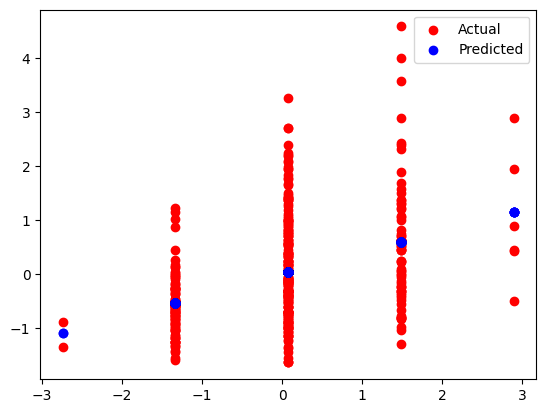

In [11]:
plt.scatter(x_train['bedrooms'], y_train, color='red', label = "Actual") # actual value
plt.scatter(x_train['bedrooms'], x_train['bedrooms']*3.991341e-01 + -3.887832e-17, color='blue', label = "Predicted" ) # Predicted value
plt.plot()
plt.legend()

Lets do the same thing for area columns as well.

<ipython-input-12-b8d7d9be96f3>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.scatter(x_train['area'], x_train['area']*simple_model_2.params[1] + simple_model_2.params[0], color='blue', label = "Predicted" )


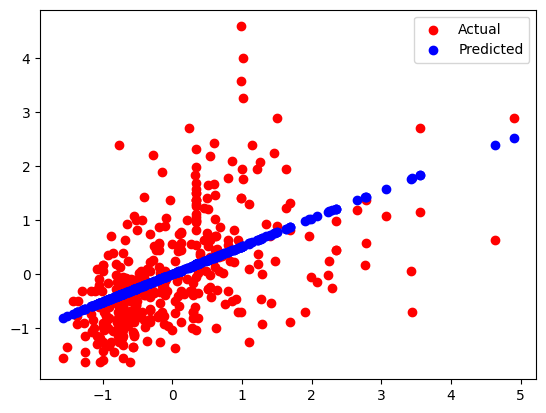

In [12]:
# adding constant and taking only area to calculate the price
simple_model_2_data = stat.add_constant(x_train['area'])
simple_model_2 = stat.OLS(y_train, simple_model_2_data).fit()

plt.scatter(x_train['area'], y_train, color='red', label = "Actual") # actual value
plt.scatter(x_train['area'], x_train['area']*simple_model_2.params[1] + simple_model_2.params[0], color='blue', label = "Predicted" )
plt.plot()
plt.legend()

Residual analysis Kdeplot should be normally distributed.
In our case, it is close to normal, there is skewness because the original data is a bit skewed. It is a good pratice to take care of the skewness first and then make a model, however, for now, we will just go for it.

Text(0.5, 1.0, 'Area')

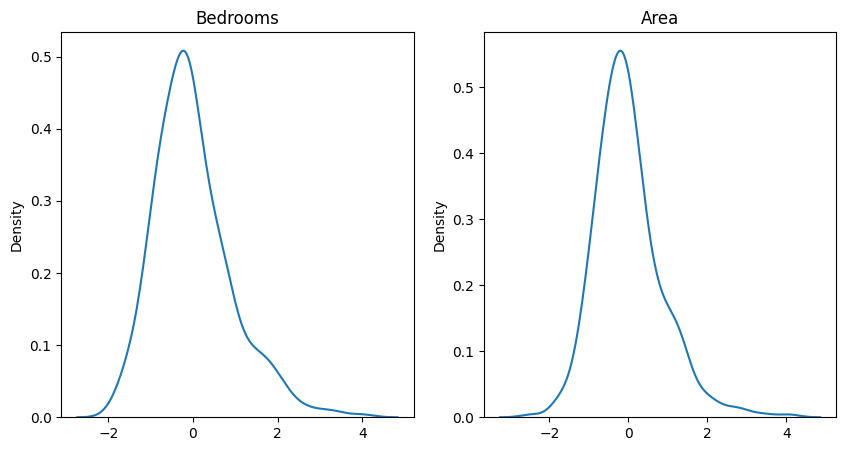

In [13]:
# Performing residual analysis on both
residual_1 = y_train - simple_model_1.predict(simple_model_1_data)

residual_2 = y_train - simple_model_2.predict(simple_model_2_data)

fig, axes = plt.subplots(1, 2, figsize=(10,5))
sns.kdeplot(residual_1, ax=axes[0])
axes[0].set_title('Bedrooms')
sns.kdeplot(residual_2, ax=axes[1])
axes[1].set_title('Area')


Look at the DW value


DW Value...................Interpretation

≈ 2..................No autocorrelation (Ideal)

< 1..................Strong positive autocorrelation (Bad)

1 to 1.5.............Moderate positive autocorrelation (Needs attention)

2.5 to 3.............Moderate negative autocorrelation (Needs attention)

> 3	.................Strong negative autocorrelation (Bad)

The Durbin-Watson (DW) test checks for autocorrelation (dependency) in residuals.

In [14]:
dw_statistic_1 = durbin_watson(residual_1)
print(f"Durbin-Watson Statistic for bedrooms: {dw_statistic_1}\n")

dw_statistic_2 = durbin_watson(residual_2)
print(f"Durbin-Watson Statistic for area: {dw_statistic_2}")

Durbin-Watson Statistic for bedrooms: 1.959806337444447

Durbin-Watson Statistic for area: 1.9736176642356693


Now, lets have a look at the model summary.

In [15]:
print(simple_model_2.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.265
Model:                            OLS   Adj. R-squared:                  0.263
Method:                 Least Squares   F-statistic:                     136.8
Date:                Sat, 01 Mar 2025   Prob (F-statistic):           3.48e-27
Time:                        16:28:20   Log-Likelihood:                -481.92
No. Observations:                 381   AIC:                             967.8
Df Residuals:                     379   BIC:                             975.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -3.888e-17      0.044  -8.83e-16      1.0

We used StandardScalar to scale the data and it produced negative numbers as well. The issue here is, price can not be in negative and so it would be better if we use MinMaxScaler to scale the data and build the model.

So, lets scale the data again.

In [16]:
num_col

['price', 'area', 'bedrooms', 'bathrooms', 'stories', 'parking']

In [17]:
scaler = MinMaxScaler()

train_copy = train.copy(deep = True)
train_copy[num_col] = scaler.fit_transform(train_copy[num_col])

test_copy = test.copy(deep = True)
test_copy[num_col] = scaler.transform(test_copy[num_col])

train_copy.head()

,price,area,bedrooms,bathrooms,stories,parking,mainroad_yes,guestroom_yes,basement_yes,hotwaterheating_yes,airconditioning_yes,prefarea_yes,furnishingstatus_semi-furnished,furnishingstatus_unfurnished
339,0.184848,0.102069,0.75,0.5,0.333333,0.000000,1,0,0,0,0,0,0,0
63,0.457576,0.321379,0.75,0.5,0.666667,0.666667,1,0,0,0,1,1,0,0
158,0.324242,0.433103,0.50,0.0,0.000000,0.666667,1,0,0,0,0,0,1,0
203,0.272727,0.255172,0.75,0.0,0.333333,0.000000,1,0,0,0,0,0,1,0
482,0.103030,0.100000,0.50,0.0,0.333333,0.000000,0,0,0,0,0,0,0,1


In [18]:
# training
x_train = train_copy.drop(['price'], axis=1)
y_train = train_copy['price']

# testing
x_test = test_copy.drop(['price'], axis=1)
y_test = test_copy['price']

<ipython-input-19-24f10b5a6bab>:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.scatter(x_train['area'], x_train['area']*simple_model_3.params[1] + simple_model_3.params[0], color='blue', label = "Predicted" )


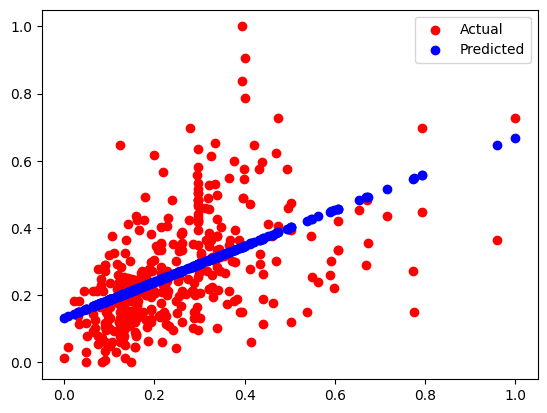

In [19]:
# adding constant and taking only area to calculate the price
simple_model_3_data = stat.add_constant(x_train['area'])
simple_model_3 = stat.OLS(y_train, simple_model_3_data).fit()
plt.scatter(x_train['area'], y_train, color='red', label = "Actual") # actual value
plt.scatter(x_train['area'], x_train['area']*simple_model_3.params[1] + simple_model_3.params[0], color='blue', label = "Predicted" )
plt.plot()
plt.legend()

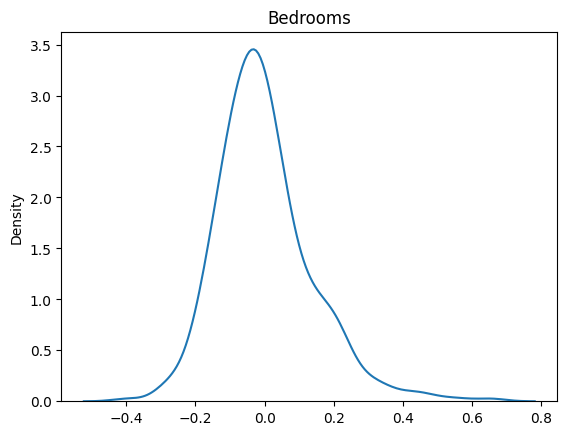

In [20]:
# Performing residual analysis
residual_3 = y_train - simple_model_3.predict(simple_model_3_data)
sns.kdeplot(residual_3).set_title('Bedrooms')

plt.show()

In [21]:
print(simple_model_3.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.265
Model:                            OLS   Adj. R-squared:                  0.263
Method:                 Least Squares   F-statistic:                     136.8
Date:                Sat, 01 Mar 2025   Prob (F-statistic):           3.48e-27
Time:                        16:28:22   Log-Likelihood:                 214.40
No. Observations:                 381   AIC:                            -424.8
Df Residuals:                     379   BIC:                            -416.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1330      0.013     10.082      0.0

# Multiple Linaer Regression

Using MinMaxScaler data

In [22]:
MLR_model_1_data = stat.add_constant(x_train)
MLR_model_1 = stat.OLS(y_train, MLR_model_1_data).fit()
print(MLR_model_1.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.672
Model:                            OLS   Adj. R-squared:                  0.660
Method:                 Least Squares   F-statistic:                     57.79
Date:                Sat, 01 Mar 2025   Prob (F-statistic):           1.96e-80
Time:                        16:28:22   Log-Likelihood:                 367.97
No. Observations:                 381   AIC:                            -707.9
Df Residuals:                     367   BIC:                            -652.7
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

We can use the value of P to refine the model.
In linear regression, the "statistically important" columns are usually identified by looking at the p-values associated with each coefficient; a low p-value (typically below 0.05) indicates that the variable has a statistically significant relationship with the dependent variable.
Here, we can remove a particular column which is not statistically important and re-train the model. The challange associated with this approach is that the model can identify an imortant factor or variable as not important and to resolve this, we have to use our domain knowledge and decide what to remove.

According to the model bedrooms,guestroom_yes, basement_yes and furnishingstatus_semi-furnished are statistically insignificant columns, but according to our domain knowledge, we are aware that bedrooms columns is actually important, the rest might not be that important. So we will remove basement column first and check if that has solved our problem.



In [23]:
vif_1 = pd.DataFrame()
vif_1["Column_name"] = x_train.columns
vif_1["VIF_value"]= [round(vif(x_train.values, value),3) for value in range(x_train.shape[1])]
vif_1 = vif_1.sort_values(by='VIF_value')
vif_1


,Column_name,VIF_value
8,hotwaterheating_yes,1.106
6,guestroom_yes,1.380
10,prefarea_yes,1.520
9,airconditioning_yes,1.723
2,bathrooms,1.758
7,basement_yes,1.806
12,furnishingstatus_unfurnished,1.812
4,parking,2.039
11,furnishingstatus_semi-furnished,2.313
3,stories,2.698


VIF is Variance inflation factor and we can use this to find the columns which have multicollinearity, this means that the columns having VIF higher than 5 are in some way related to other columns apart from the dependent variable, that is price in this data. This multicollinearity will create a problem and we need to get rid of these columns, however, before droping these columns, we must consider the domain knowledge and than decide.

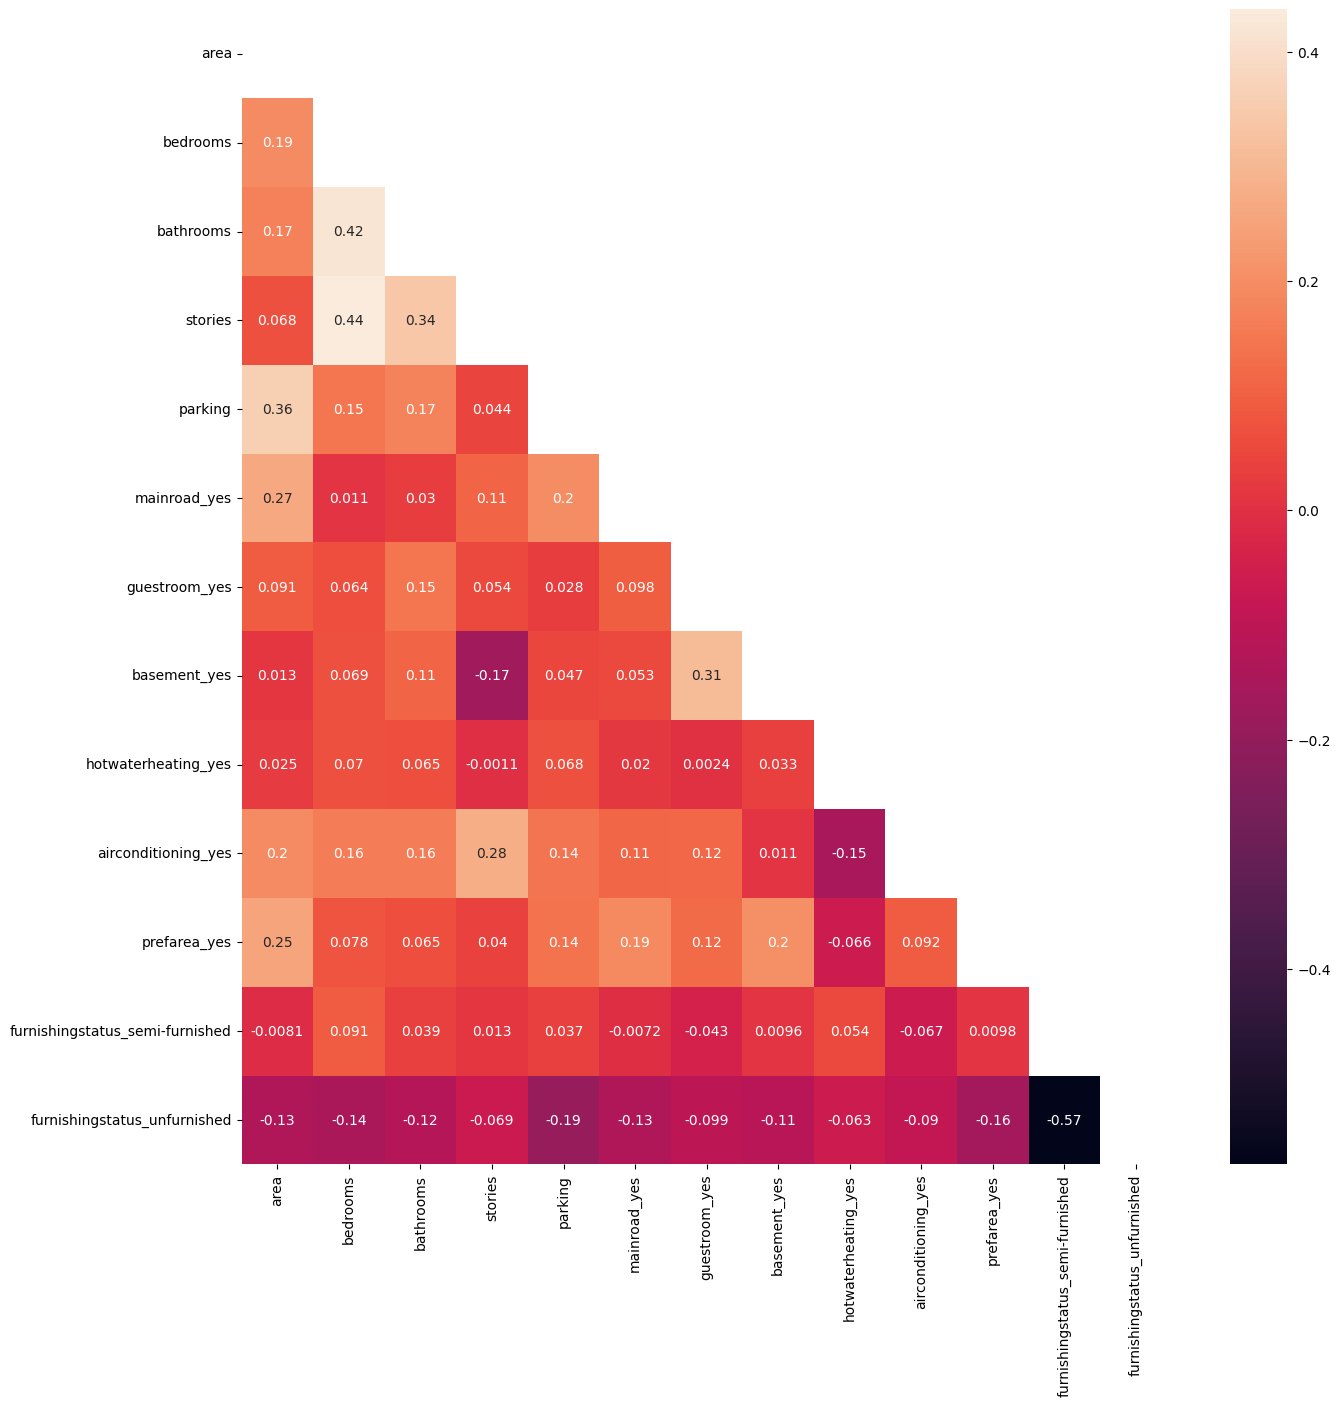

In [24]:
# We can also look at the heatmap created from the training data to find multicollinearity.
plt.figure(figsize=(15,15))
sns.heatmap(x_train.corr(), annot = True, mask = np.triu(x_train.corr()))
plt.show()

In this heat map, we can see the correlation of all the columns with each other. Some of the columns have high correlation and this is not good for the model.

In [25]:
# lets remove furnishingstatus_semi-furnished columns and train the model again
x_train = x_train.drop("furnishingstatus_semi-furnished", axis = 1)
x_train.head()

,area,bedrooms,bathrooms,stories,parking,mainroad_yes,guestroom_yes,basement_yes,hotwaterheating_yes,airconditioning_yes,prefarea_yes,furnishingstatus_unfurnished
339,0.102069,0.75,0.5,0.333333,0.000000,1,0,0,0,0,0,0
63,0.321379,0.75,0.5,0.666667,0.666667,1,0,0,0,1,1,0
158,0.433103,0.50,0.0,0.000000,0.666667,1,0,0,0,0,0,0
203,0.255172,0.75,0.0,0.333333,0.000000,1,0,0,0,0,0,0
482,0.100000,0.50,0.0,0.333333,0.000000,0,0,0,0,0,0,1


In [26]:
MLR_model_2_data = stat.add_constant(x_train)
MLR_model_2 = stat.OLS(y_train, MLR_model_2_data).fit()
print(MLR_model_2.summary())
print(".......................................................\n")
vif_1 = pd.DataFrame()
vif_1["Column_name"] = x_train.columns
vif_1["VIF_value"]= [round(vif(x_train.values, value),3) for value in range(x_train.shape[1])]
vif_1 = vif_1.sort_values(by='VIF_value')
print(vif_1)
print(".......................................................\n")

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.672
Model:                            OLS   Adj. R-squared:                  0.661
Method:                 Least Squares   F-statistic:                     62.78
Date:                Sat, 01 Mar 2025   Prob (F-statistic):           2.42e-81
Time:                        16:28:23   Log-Likelihood:                 367.97
No. Observations:                 381   AIC:                            -709.9
Df Residuals:                     368   BIC:                            -658.7
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

In [27]:
# Now, lets remove basement_yes
x_train = x_train.drop("basement_yes", axis = 1)

MLR_model_3_data = stat.add_constant(x_train)
MLR_model_3 = stat.OLS(y_train, MLR_model_3_data).fit()
print(MLR_model_3.summary())
print(".......................................................\n")
vif_1 = pd.DataFrame()
vif_1["Column_name"] = x_train.columns
vif_1["VIF_value"]= [round(vif(x_train.values, value),3) for value in range(x_train.shape[1])]
vif_1 = vif_1.sort_values(by='VIF_value')
print(vif_1)
print(".......................................................\n")


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.669
Model:                            OLS   Adj. R-squared:                  0.659
Method:                 Least Squares   F-statistic:                     67.88
Date:                Sat, 01 Mar 2025   Prob (F-statistic):           1.18e-81
Time:                        16:28:23   Log-Likelihood:                 366.48
No. Observations:                 381   AIC:                            -709.0
Df Residuals:                     369   BIC:                            -661.7
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

We can repeat this until we are satisfied. This data that we have used is very small and the target column is right skewed, which I haven't fixed, so the accuracy will remain low.

In [28]:
x_testing_data = stat.add_constant(x_test)
x_testing_data = x_testing_data.drop(["furnishingstatus_semi-furnished", "basement_yes"], axis = 1)
x_testing_data.head()

,const,area,bedrooms,bathrooms,stories,parking,mainroad_yes,guestroom_yes,hotwaterheating_yes,airconditioning_yes,prefarea_yes,furnishingstatus_unfurnished
333,1.0,0.089655,0.50,0.0,0.333333,0.000000,1,0,0,0,0,0
37,1.0,0.503448,0.75,0.5,1.000000,0.666667,1,0,0,1,0,0
396,1.0,0.133793,0.25,0.0,0.000000,0.333333,1,0,0,0,0,0
494,1.0,0.351724,0.25,0.0,0.000000,0.000000,1,0,0,0,0,1
536,1.0,0.118621,1.00,0.0,0.333333,0.000000,0,0,0,0,0,1


In [29]:
# we can use this data to test the model
y_pred = MLR_model_3.predict(x_testing_data)
print("Testing accuracy is: ", r2_score(y_test, y_pred)*100, "%")

Testing accuracy is:  67.966013202477 %


# Linear regression model using sklearn

In [30]:
# Training
x_train = train_copy.drop(['price'], axis=1)
y_train = train_copy['price']

# testing
x_test = test_copy.drop(['price'], axis=1)
y_test = test_copy['price']

In [31]:
mod1 = LR().fit(x_train, y_train)
print(mod1.score(x_train, y_train))

0.671832588253032


In [32]:
y_pred_sk = mod1.predict(x_test)
print(f"Mean squared error: {mean_squared_error(y_test, y_pred)}")
print(f"Coefficient of determination: {r2_score(y_test, y_pred)}")

Mean squared error: 0.00861526304983321
Coefficient of determination: 0.6796601320247699
